In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

In [2]:
raw_data = pd.read_csv("data/raw_data.txt", skiprows=5, encoding="latin-1", delimiter = "	", header=None, na_filter=True, usecols=list(range(1,10)))

In [3]:
raw_data

,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
507,0,0,0,0,0,0,0,0,0
508,0,0,0,0,0,0,0,0,0
509,0,0,0,0,0,0,0,0,0
510,0,0,0,0,0,0,0,0,0


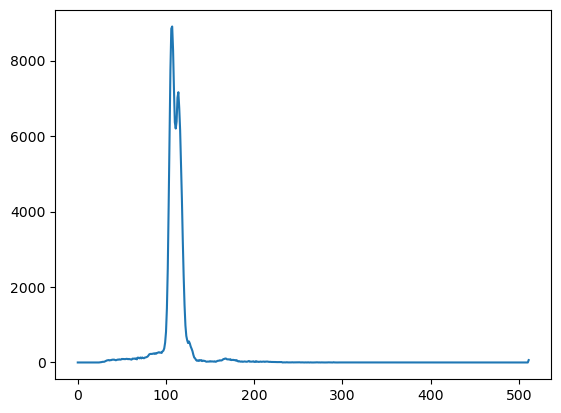

In [4]:
plt.plot(raw_data.iloc[:,7])
plt.show()

In [5]:
def callibration(n1,n2,E1,E2):
    m = (E2-E1)/(n2-n1)
    c = E2-m*n2
    return m, c